In [1]:
%pylab inline
import yt 
yt.mylog.setLevel(50) #suppress yt outputs 

Populating the interactive namespace from numpy and matplotlib


To analyze the hdf5  files that the simulation outputs,we will be using yt, a well-supported Python package for visualizing volumetric, AMR data from astrophysical simulations. For more information, refer to the excellent [yt documentation](http://yt-project.org/docs/3.2/) and [series of notebook tutorials](http://yt-project.org/docs/dev/quickstart/index.html) that is much more comprehensive than what is covered here. In this notebook, we will be covering yt basics, as well as using some custom scripts used for analyzing the FLASH data in ``plotSim.py`` that I wrote.

In [2]:
from scripts.plotSim import *

/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [24]:
cd ~/data_astroSim/data/

/global/u2/d/dorislee/data_astroSim/data


## Exploratory Data Analysis

Loading in the dataset for the last timestep in our Rotating Sink Sphere simulation: 

In [8]:
ds = yt.load("sphere_hdf5_chk_0494")

By default, FLASH outputs its data in cgs (except in MHD..), so the code units in yt is actually in cgs.

In [53]:
print ds.length_unit,ds.mass_unit,ds.time_unit 

1.0 cm 1.0 g 1.0 s


Often useful information about a simulation timestep output: 
    

In [56]:
print "Current simulation timestep:", ds.current_time

Current simulation timestep: 4.94073212769e+12 code_time


Here is a list of variables that are stored in the simulation outputs, note that some variables (e.g mag) will not have data (since this is a hydro run):

In [52]:
print map(lambda x:str(x[1]),filter(lambda x :x[0]=='flash',ds.field_list))

['dens', 'divb', 'eint', 'ener', 'gamc', 'game', 'gpol', 'gpot', 'grac', 'magp', 'magx', 'magy', 'magz', 'pden', 'pres', 'sgax', 'sgay', 'sgaz', 'sgxo', 'sgyo', 'sgzo', 'shok', 'temp', 'velx', 'vely', 'velz']


This is just a demo of the long list of variables that yt can derive from the few variables stored in the simulation as shown above:

In [35]:
print map(lambda x: x[1],ds.field_info.keys())[:15]

['particle_position_cylindrical_z', 'cylindrical_theta', 'particle_angular_momentum_z', u'game', 'particle_radius', u'divb', 'total_energy', 'particle_position_cylindrical_radius', 'density_gradient_magnitude', 'particle_cylindrical_velocity_theta', 'pressure', 'particle_velocity_z', 'particle_position_spherical_radius', 'magnetic_field_strength', 'io_nn_velocity_x']


# SlicePlots

We many things we can do on the yt dataset ``ds``, such as making SlicePlots, create a volumetric rendering, or making radial profiles by cutting through the simulation box.

Here we make a SlicePlot of the density through the z direction


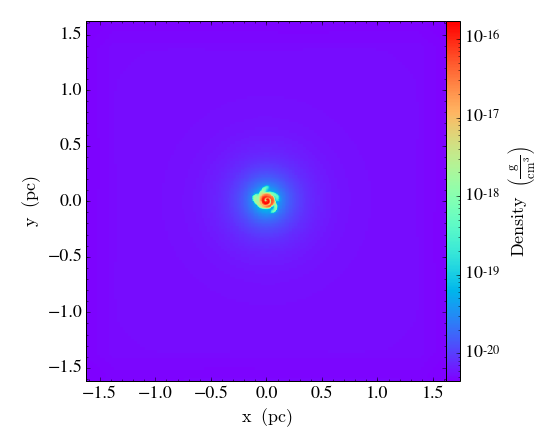

In [59]:
slc = yt.SlicePlot(ds, "z","density")
slc.set_figure_size(5) #sets the size of the plot
slc.set_cmap("all","rainbow")

We can plot what the AMR grid looks like. In this simulation, we are using Jean's criterion based AMR refinement.  The AMR structure would look quite different if we used density based refinement (which refines based on density gradients across cells). Note that the grid lines that yt is drawing denotes where the *blocks* are __NOT__ where the *cells* are. (Recall that each block consists of 8 cells)


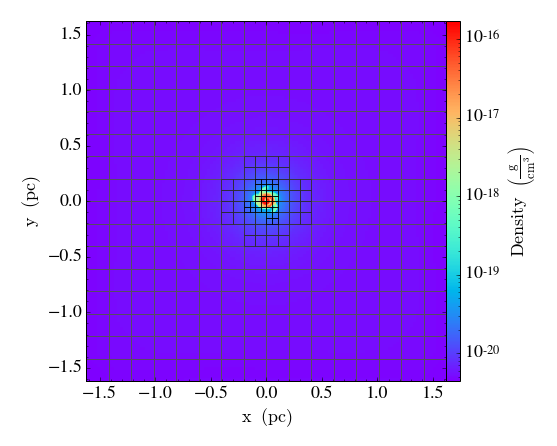

In [67]:
slc.annotate_grids()

We can also do fancy things like zooming in and plotting the velocity vectors.


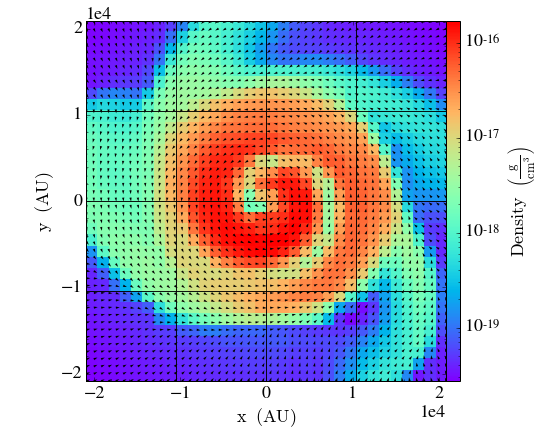

In [61]:
slc.zoom(4)
slc.annotate_grids()
slc.annotate_velocity(normalize=True)

zlim defines the limits on the colorbar for the variable that you are plotting. This is sometimes useful when we are looking at data across many timesteps.

~~~python
slc.set_zlim("density",zmin,zmax)

~~~


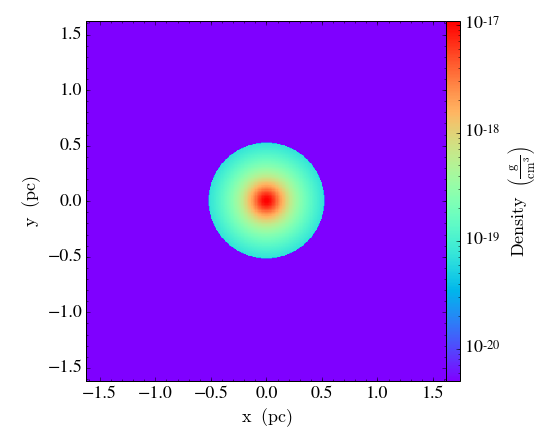

In [4]:
plot_dens(0,fname="sphere")


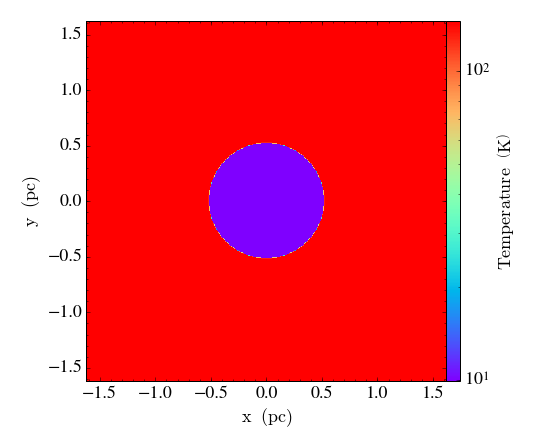


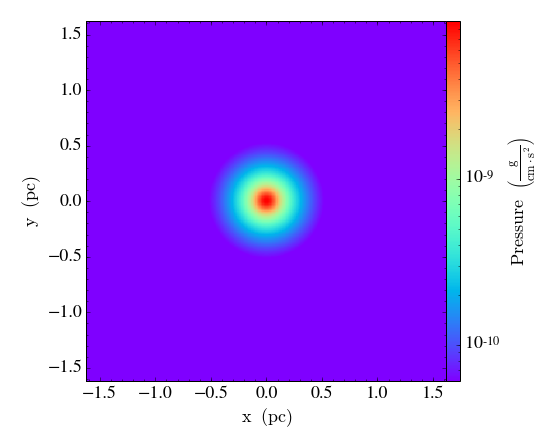

In [25]:
plot_var(0,"temperature", "sphere")
plot_var(0,"pressure", "sphere")

Without fixing the colorbar,


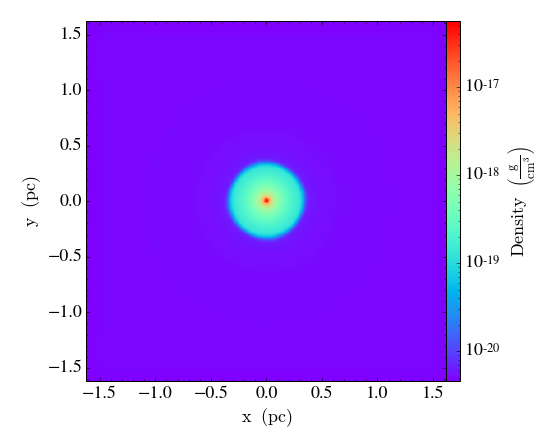

In [7]:
plot_dens(300,fname="sphere")

Fixing the colorbar,


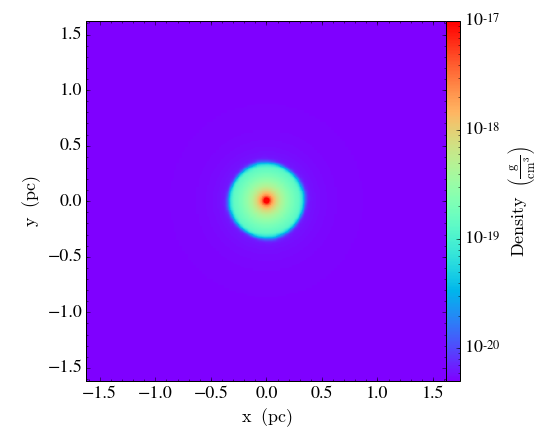

In [8]:
plot_dens(300,fname="sphere",zmin = 5e-21,zmax = 1e-17)

As shown above, fixing the colorbar allows us to compare our simulation against the initial conditions. For example we may be interested in seeing which areas of the sphere experience a density increase compared to the initial sphere, rather than by *how much* does the density increase. On the other hand, allowing the colorbar to vary enable us to see more detailed structures that might be saturated if we retained the initial color scheme. It is important to think about whether the visualization settings may affect what we see in the data. 



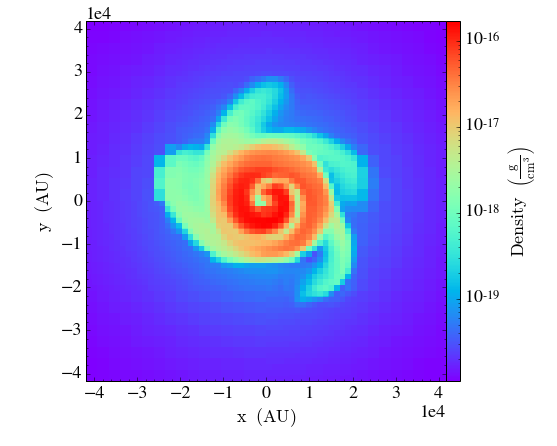

In [11]:
plot_dens(494,fname="sphere",zoom=8)


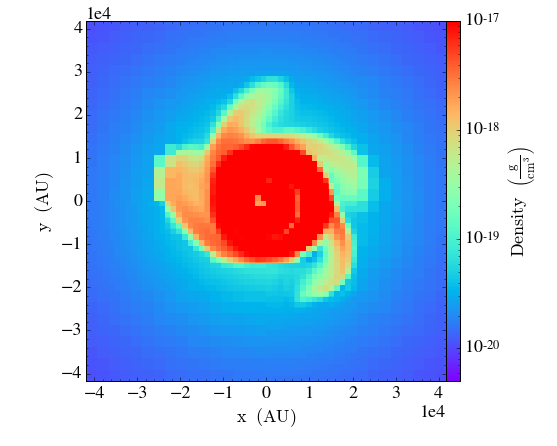

In [12]:
plot_dens(494,fname="sphere",zoom=8,zmin = 5e-21,zmax = 1e-17)

# Adding user-defined parameters

Even though yt has a comprehensive list of derived variables , sometimes it is useful to define our own parameters. For example, Foster and Chevalier (1993) defines a set of non-dimensional units used for their plots, so in order to compare our simulation result to theirs, we must additionally convert into these nondimensional units. 
\begin{align}
D = \frac{\rho}{\rho_c} = 9.09\times 10^{18}\rho
\\ m = \frac{GM\sqrt{4\pi G\rho_c}}{a^3}=8.54\times10^{-34} M
\\v = \frac{u}{a} = 3.48\times10^{-5} u 
\\ \xi =\frac{\sqrt{4\pi G \rho_c}}{a} r = 1.0568\times10^{-17} r 
\\ \tau = \sqrt{4\pi G \rho_c} t  = 3.036\times 10^{-13} t 
\end{align}
where $\rho$, M, u, r,t are in cgs units.



In [1]:
%pylab inline
import yt
yt.mylog.setLevel(50)
from yt.units import second, g, cm ,dyne
G = 6.674e-8*cm**3/second**2/g
rho_c = 1.1e-17*g/cm**3
conversion = sqrt(4*pi*G*rho_c)
aT  = 28730*cm/second # for 10K gas 
ctr= 5e18*cm
def _radius(field,data):
    radius = sqrt((data["x"]-ctr)**2+(data["y"]-ctr)**2+(data["z"]-ctr)**2)
def _norm_r(field,data):
    return data["radius"]*conversion/aT
def _norm_v(field,data):
    return data["radial_velocity"]/aT
def _norm_d(field,data):
    return data["density"]/rho_c
yt.add_field("radius",function= _radius,units="cm")
yt.add_field("norm_r",function= _norm_r,units="")
yt.add_field("norm_v",function= _norm_v,units="")
yt.add_field("norm_d",function= _norm_d,units="")
ds = yt.load("../../data_astroSim/data/sphere_hdf5_chk_0000")
data = ds.all_data()

Populating the interactive namespace from numpy and matplotlib


Now the units are non-dimensional 

In [2]:
print data["norm_r"]
print data["norm_v"]
print data["norm_d"]

[ 908.41256519  903.6691589   898.97660951 ...,  898.97660951  903.6691589
  908.41256519] dimensionless
[  9.89269385e-19   4.94634692e-19   1.48390408e-18 ...,   0.00000000e+00
  -4.94634692e-19   0.00000000e+00] dimensionless
[ 0.00045455  0.00045455  0.00045455 ...,  0.00045455  0.00045455
  0.00045455] dimensionless


We can now use these non-dimensional, derived fields in a profile plot: 


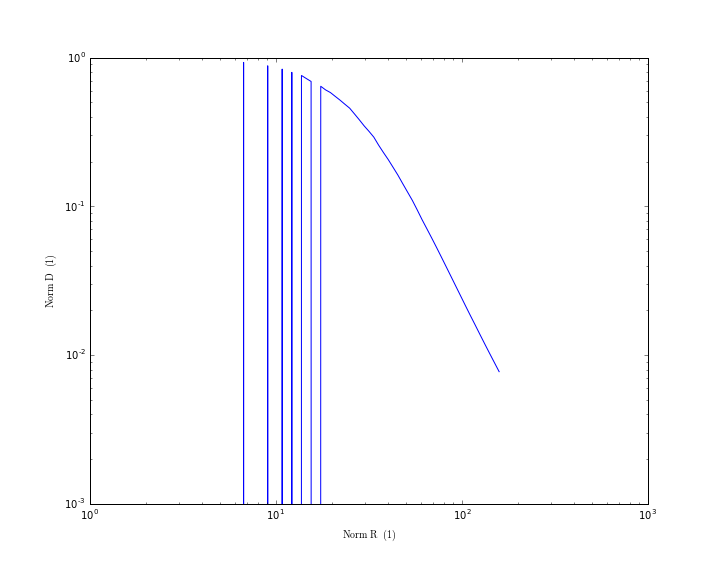

In [19]:
sphere = ds.sphere("c", (0.5, "pc"))
prof = yt.ProfilePlot(sphere, "norm_r","norm_d")
prof.show()

# FixedResolutionBuffer


turns your AMR data into a 2D or 3D numpy array which you can then use for plotting in 
If you are used to matplotlib or other plotting library 
I find that generally plotting with --- yt is sufficient and usually better than whatever ----, but FRBs are especially useful for quantitatively analyzing the data. For example in scripts/----, M/R plots 

In [ ]:
Inside, scripts/

In [15]:
cd ~/proj/dlee/FLASH4.3/object/

/global/project/projectdirs/astro250/dlee/FLASH4.3/object


In [18]:
ls sphere*

sphere.dat            sphere_hdf5_part_0000     sphere.log
sphere_hdf5_chk_0000  sphere_hdf5_plt_cnt_0000



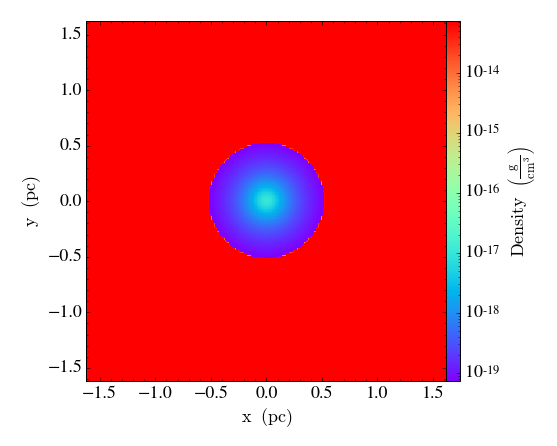

In [19]:
plot_dens(0,"sphere")


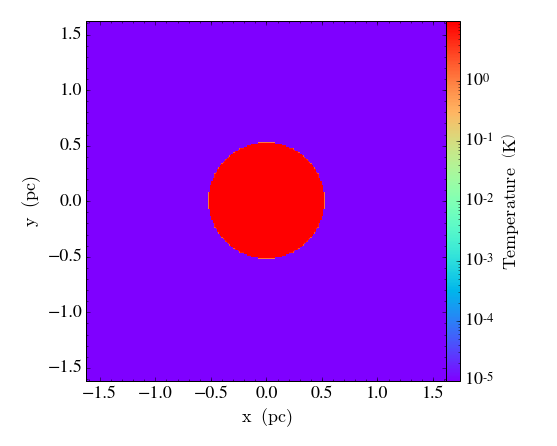

In [21]:
plot_var(0,"temperature", "sphere")


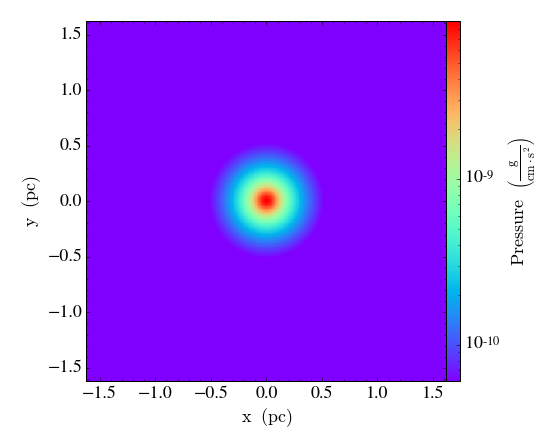

In [23]:
plot_var(0,"pressure", "sphere")